# Indian Ocean Song

The objective of this notebook is to follow all the steps to get data and turn into music specifically for Indian Ocean, but creating functions that can be used later for other oceans.

We will also create assets to be used later, instead of running code all the time to get the data.


The steps will be:
1. Divide the buoys into oceans, and save it as an asset to be used later
1. Get all data from the oceans, and save it as an asset
1. Run the data through functions to convert it into musical base
1. After doing musical base, go further and turn them into specific modes and deal with other mussical concepts like tempo, note duration, etc.

## Step 1: Divide the buoys into oceans, and save it as an asset to be used later

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import folium

from ndbc_api import NdbcApi

api = NdbcApi()

### Get data from API

In [3]:
# get all stations and some metadata as a Pandas DataFrame
stations_df = api.stations()

buoy_df = stations_df[stations_df['Type'] == 'buoy']

# Only include buoys with meteorology data and clean the data of unused columns

buoy_df = buoy_df[buoy_df['Includes Meteorology'] == True]
buoy_df = buoy_df.drop(columns=['Type', 'Includes Meteorology', 'Includes Currents',
                       'Includes Water Quality', 'DART Program']).reset_index(drop=True)

# Create a GeoDataFrame from the buoy locations
buoy_df['geometry'] = buoy_df.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
buoys_gdf = gpd.GeoDataFrame(buoy_df, geometry='geometry')

# Load the GeoJSON file
oceans_gdf = gpd.read_file('5oceansByNick.geojson')

# Ensure both GeoDataFrames are using the same coordinate reference system (CRS)
# If the oceans GeoDataFrame is in a different projection, you may need to convert it
buoys_gdf.crs = oceans_gdf.crs

# Perform a spatial join to find which ocean each buoy belongs to
buoy_df = gpd.sjoin(buoys_gdf, oceans_gdf, how="left", predicate='within')

# The resulting DataFrame will have an additional column with ocean names
print(buoy_df[['Lat', 'Lon', 'name']])  # Shows latitude, longitude and corresponding ocean name

# Drop unnecessary columns, and change name for Ocean

buoy_df = buoy_df.drop(columns=['geometry', 'index_right'])
buoy_df = buoy_df.rename(columns={'name': 'Ocean'})

buoy_df.head()

        Lat     Lon            name
0    12.000 -23.000  Atlantic Ocean
1    21.000 -23.000  Atlantic Ocean
2    15.000 -38.000  Atlantic Ocean
3     8.000 -38.000  Atlantic Ocean
4    -8.000  65.000    Indian Ocean
..      ...     ...             ...
271  47.550  -8.470  Atlantic Ocean
272  49.000 -16.500  Atlantic Ocean
273  59.150 -11.790  Atlantic Ocean
274  39.223 -76.540  Atlantic Ocean
275  33.838 -78.484  Atlantic Ocean

[276 rows x 3 columns]


,Station,Lat,Lon,Elevation,Name,Owner,Program,Ocean
0,13001,12.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
1,13002,21.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
2,13008,15.0,-38.0,0.0,Reggae,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
3,13009,8.0,-38.0,0.0,Lambada,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
4,14048,-8.0,65.0,0.0,,Research Moored Array for African-Asian-Austra...,International Partners,Indian Ocean


### Save into an asset


In [5]:
buoy_df.to_csv('buoys_with_ocean.csv', index=False)


In [6]:
del(buoy_df)

In [7]:
# Confirm it was deleted. this should throw an error.
# buoy_df

In [8]:
# ReRading the df
buoy_df = pd.read_csv('buoys_with_ocean.csv')
buoy_df.head()

,Station,Lat,Lon,Elevation,Name,Owner,Program,Ocean
0,13001,12.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
1,13002,21.0,-23.0,0.0,NE Extension,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
2,13008,15.0,-38.0,0.0,Reggae,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
3,13009,8.0,-38.0,0.0,Lambada,Prediction and Research Moored Array in the At...,International Partners,Atlantic Ocean
4,14048,-8.0,65.0,0.0,NaN,Research Moored Array for African-Asian-Austra...,International Partners,Indian Ocean


### Show the buoys in the map

In [7]:
# Create a Folium map centered around the average of the buoy coordinates
m = folium.Map(location=[buoy_df['Lat'].mean(), buoy_df['Lon'].mean()], zoom_start=2)

# Add ocean polygons from GeoJSON
folium.GeoJson(
    oceans_gdf.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'lightblue',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(m)

# Define a color mapping for each ocean
ocean_colors = {
    'Atlantic Ocean': 'blue',
    'Pacific Ocean America': 'green',
    'Indian Ocean': 'red',
    'Southern Ocean': 'purple',
    'Pacific Ocean Asia': 'green'
}

# Add buoy locations to the map
for idx, row in buoy_df.iterrows():
    # Get the color for the current ocean, default to orange if not found
    icon_color = ocean_colors.get(row['Ocean'], 'orange')
    
    folium.Marker(
        location=(row['Lat'], row['Lon']),
        popup=f'Buoy {row["Station"]}\n ({row["Lat"]}, {row["Lon"]})\n{row["Ocean"]}',
        icon=folium.Icon(color=icon_color)
    ).add_to(m)
# Save the map to an HTML file
m.save('buoy_ocean_map.html')

# Display the map
m

## Step 2: Get all data from the oceans, and save it as an asset


### Get data from API

In [8]:
import pandas as pd
from datetime import datetime

def fetch_buoy_data(buoy_df, start_time, end_time=None):
    # If end_time is not provided, use today's date
    if end_time is None:
        end_time = datetime.now().strftime('%Y-%m-%d')
    
    # Ensure start_time and end_time are in the correct format
    start_time = pd.to_datetime(start_time).strftime('%Y-%m-%d')
    end_time = pd.to_datetime(end_time).strftime('%Y-%m-%d')

    stations = buoy_df['Station'].unique()
    variables = ['WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'PTDY']

    # Create a DataFrame to store availability
    availability = pd.DataFrame(index=stations, columns=variables, dtype=int)
    availability.fillna(0, inplace=True)

    # Dictionary to store data for each station
    station_data = {}

    for station in stations:
        try:
            # Fetch data for each station
            df = api.get_data(
                station_id=station,
                mode='stdmet',
                start_time=start_time,
                end_time=end_time,
            )
            
            # Store the data in the dictionary
            station_data[station] = df
            
            # Update availability DataFrame
            for var in variables:
                if var in df.columns and not df[var].isna().all():
                    availability.loc[station, var] = 1
        except Exception as e:
            print(f"Error fetching data for station {station}: {str(e)}")

    # Ensure all data in availability is numeric
    availability = availability.astype(int)

    return station_data, availability


: 

In [9]:
# Example usage:
station_data, availability_df = fetch_buoy_data(buoy_df, start_time='2024-06-01')

NameError: name 'fetch_buoy_data' is not defined

In [20]:
availability_df

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY
13001,1,1,1,0,0,0,0,1,1,1,0,0,0
13002,0,0,0,0,0,0,0,0,0,1,0,0,0
13008,1,1,1,0,0,0,0,1,1,1,0,0,0
13009,1,1,0,0,0,0,0,0,1,1,0,0,0
14048,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62163,0,0,0,0,0,0,0,0,0,0,0,0,0
62442,0,0,0,0,0,0,0,0,0,0,0,0,0
64045,0,0,0,0,0,0,0,0,0,0,0,0,0
cbcm2,1,1,1,0,0,0,0,1,1,1,1,0,1


In [21]:
station_data

{'13001':                      WDIR  WSPD  GST  WVHT  DPD  APD  MWD    PRES  ATMP  WTMP  \
 timestamp                                                                       
 2024-08-03 00:00:00   327   6.3  7.3   NaN  NaN  NaN  NaN  1010.9  27.6  28.1   
 2024-08-03 01:00:00   325   5.1  6.3   NaN  NaN  NaN  NaN  1010.9  27.6  28.0   
 2024-08-03 02:00:00   339   5.1  6.3   NaN  NaN  NaN  NaN  1010.0  27.5  28.0   
 2024-08-03 03:00:00   322   5.5  6.8   NaN  NaN  NaN  NaN  1009.4  27.6  28.0   
 2024-08-03 04:00:00   333   3.6  5.0   NaN  NaN  NaN  NaN  1009.2  27.5  28.0   
 ...                   ...   ...  ...   ...  ...  ...  ...     ...   ...   ...   
 2024-09-15 20:00:00   222   1.4  2.6   NaN  NaN  NaN  NaN  1013.9  28.0  29.2   
 2024-09-15 21:00:00   317   2.0  3.6   NaN  NaN  NaN  NaN  1014.3  27.4  29.0   
 2024-09-15 22:00:00   270   2.4  3.4   NaN  NaN  NaN  NaN  1014.8  28.0  28.9   
 2024-09-15 23:00:00   311   4.6  5.9   NaN  NaN  NaN  NaN  1014.8  27.5  28.9   
 2024-0

In [22]:
list(station_data.keys())


['13001',
 '13002',
 '13008',
 '13009',
 '14048',
 '14049',
 '15001',
 '15002',
 '15006',
 '23001',
 '23003',
 '23012',
 '23013',
 '23014',
 '23015',
 '23016',
 '23019',
 '31001',
 '31002',
 '31003',
 '31004',
 '31005',
 '31006',
 '31007',
 '41001',
 '41008',
 '41009',
 '41010',
 '41013',
 '41024',
 '41025',
 '41029',
 '41033',
 '41037',
 '41038',
 '41040',
 '41044',
 '41052',
 '41053',
 '41056',
 '41065',
 '41066',
 '41067',
 '41069',
 '41070',
 '41076',
 '41082',
 '41083',
 '41108',
 '41110',
 '41112',
 '41113',
 '41114',
 '41115',
 '41117',
 '41120',
 '41122',
 '41139',
 '41159',
 '42012',
 '42013',
 '42019',
 '42020',
 '42023',
 '42026',
 '42036',
 '42057',
 '42085',
 '42091',
 '42092',
 '42095',
 '42097',
 '42098',
 '44007',
 '44008',
 '44009',
 '44013',
 '44014',
 '44029',
 '44030',
 '44032',
 '44033',
 '44034',
 '44041',
 '44042',
 '44043',
 '44056',
 '44058',
 '44062',
 '44063',
 '44064',
 '44072',
 '44078',
 '44079',
 '44084',
 '44085',
 '44086',
 '44087',
 '44088',
 '44089',


In [23]:
station_data["23019"]

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
timestamp,,,,,,,,,,,,,,
2024-08-03 00:00:00,152.0,7.3,8.8,NaN,NaN,NaN,NaN,NaN,28.0,28.8,NaN,NaN,NaN,NaN
2024-08-03 01:00:00,158.0,7.5,9.8,NaN,NaN,NaN,NaN,NaN,28.1,28.8,NaN,NaN,NaN,NaN
2024-08-03 02:00:00,157.0,8.2,9.9,NaN,NaN,NaN,NaN,NaN,27.8,28.8,NaN,NaN,NaN,NaN
2024-08-03 03:00:00,180.0,6.9,8.7,NaN,NaN,NaN,NaN,NaN,27.7,28.9,NaN,NaN,NaN,NaN
2024-08-03 04:00:00,170.0,6.9,8.1,NaN,NaN,NaN,NaN,NaN,27.3,28.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-15 20:00:00,136.0,7.7,8.7,NaN,NaN,NaN,NaN,NaN,28.5,29.2,NaN,NaN,NaN,NaN
2024-09-15 21:00:00,129.0,7.5,8.7,NaN,NaN,NaN,NaN,NaN,28.4,29.2,NaN,NaN,NaN,NaN
2024-09-15 22:00:00,128.0,7.5,9.0,NaN,NaN,NaN,NaN,NaN,28.3,29.2,NaN,NaN,NaN,NaN


In [24]:
def clean_station_data(station_data, availability):
    cleaned_data = {}
    
    for station, df in station_data.items():
        if station in availability.index:
            available_columns = availability.loc[station][availability.loc[station] == 1].index.tolist()
            
            # Keep only the available columns
            cleaned_df = df[available_columns].copy()
            
            # Ensure the index is datetime
            cleaned_df.index = pd.to_datetime(cleaned_df.index)
            
            # Remove rows where all data columns are NaN
            cleaned_df = cleaned_df.dropna(how='all')
            
            # Only add the station to cleaned_data if it has any remaining data
            if not cleaned_df.empty:
                cleaned_data[station] = cleaned_df
        else:
            print(f"Warning: Station {station} not found in availability DataFrame")
    
    return cleaned_data



In [25]:
# Example usage:
cleaned_station_data = clean_station_data(station_data, availability_df)

In [26]:
cleaned_station_data["23019"]

,WDIR,WSPD,GST,ATMP,WTMP
timestamp,,,,,
2024-08-03 00:00:00,152.0,7.3,8.8,28.0,28.8
2024-08-03 01:00:00,158.0,7.5,9.8,28.1,28.8
2024-08-03 02:00:00,157.0,8.2,9.9,27.8,28.8
2024-08-03 03:00:00,180.0,6.9,8.7,27.7,28.9
2024-08-03 04:00:00,170.0,6.9,8.1,27.3,28.9
...,...,...,...,...,...
2024-09-15 20:00:00,136.0,7.7,8.7,28.5,29.2
2024-09-15 21:00:00,129.0,7.5,8.7,28.4,29.2
2024-09-15 22:00:00,128.0,7.5,9.0,28.3,29.2


### Graph data availability

In [27]:
import plotly.graph_objects as go

def plot_availability_heatmap(availability):
    # Remove columns (variables) with no data
    availability = availability.loc[:, (availability != 0).any(axis=0)]
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=availability.values,
        x=availability.columns,
        y=availability.index,
        colorscale='YlGnBu',
        colorbar=dict(title='Data Available')
    ))
    
    # Update layout
    fig.update_layout(
        title='Data Availability by Station and Variable',
        xaxis_title='Variable',
        yaxis_title='Station',
        height=600,
        width=1000
    )
    
    # Show the plot
    fig.show()


In [28]:
# Call the function with your availability dataframe
plot_availability_heatmap(availability_df)

### Store data as asset

In [29]:
%pip install tables

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
from datetime import datetime

def store_buoy_data(cleaned_station_data, availability_df):
    # Analyze timestamp range
    start_date = datetime.now()
    end_date = datetime.min
    
    for df in cleaned_station_data.values():
        if not df.empty:
            df_start = df.index.min()
            df_end = df.index.max()
            start_date = min(start_date, df_start)
            end_date = max(end_date, df_end)
    
    # Format dates for filename
    start_str = start_date.strftime('%Y%m%d')
    end_str = end_date.strftime('%Y%m%d')
    
    # Create filename
    filename = f'buoy_data_{start_str}_to_{end_str}.h5'
    
    # Save data to HDF5 file
    with pd.HDFStore(filename) as store:
        store['availability'] = availability_df
        for station, df in cleaned_station_data.items():
            store[f'station_{station}'] = df
    
    print(f"Data stored in {filename}")
    return filename

def load_buoy_data(filename):
    with pd.HDFStore(filename) as store:
        availability_df = store['availability']
        station_data = {}
        for key in store.keys():
            if key.startswith('/station_'):
                station = key.split('_', 1)[1]
                station_data[station] = store[key]
    
    return station_data, availability_df

In [31]:
# Example usage:
# Storing data
filename = store_buoy_data(cleaned_station_data, availability_df)
print(filename)


Data stored in buoy_data_20240601_to_20240916.h5
buoy_data_20240601_to_20240916.h5


In [16]:

# Loading data
cleaned_station_data, availability_df = load_buoy_data('buoy_data_20240601_to_20240916.h5')


## Step 3: Run the data through functions to convert it into musical base

The analysis here is valid for Indian Ocean, as data has been reviewed before.

In [17]:
variable_ranges = {
    'WDIR': (0, 360),       # Wind direction in degrees
    'WSPD': (0, 14),        # Wind speed in m/s (adjust max as needed)
    'GST': (2, 16),         # Wind gust speed in m/s (adjust max as needed)
    'PRES': (1006, 1018),   # Atmospheric pressure in hPa
    'ATMP': (24, 30),       # Air temperature in °C
    'WTMP': (26, 31)        # Water temperature in °C
}

output_octaves = 3

In [18]:
def filter_by_ocean(availability_df, cleaned_station_data, buoys_df, ocean_name):
    # Filter buoys_df to get stations from the specified ocean
    ocean_stations = buoys_df[buoys_df['Ocean'] == ocean_name]['Station'].tolist()

    # Filter availability_df
    filtered_availability = availability_df.loc[availability_df.index.intersection(ocean_stations)]
    
    # Remove columns filled with zero
    filtered_availability = filtered_availability.loc[:, (filtered_availability != 0).any(axis=0)]

    # Filter cleaned_station_data
    filtered_station_data = {station: data for station, data in cleaned_station_data.items() if station in ocean_stations}

    return filtered_availability, filtered_station_data

In [19]:
# Example usage:
filtered_availability, filtered_station_data = filter_by_ocean(availability_df, cleaned_station_data, buoy_df, "Indian Ocean")


In [20]:
filtered_availability

,WDIR,WSPD,GST,PRES,ATMP,WTMP
14048,0,0,0,0,0,1
14049,1,1,1,1,1,1
23001,1,1,0,1,1,1
23003,1,1,0,0,1,1
23012,1,1,0,0,1,1
23013,1,1,0,0,1,1
23014,1,1,0,0,1,1
23015,1,1,0,0,1,1
23016,1,1,0,0,1,1
23019,1,1,1,0,1,1


In [21]:
filtered_station_data["23012"]

,WDIR,WSPD,ATMP,WTMP
timestamp,,,,
2024-08-11 12:00:00,NaN,NaN,NaN,29.0
2024-08-12 12:00:00,NaN,NaN,NaN,29.3
2024-08-12 20:00:00,288.0,7.3,28.8,29.2
2024-08-12 23:00:00,287.0,7.1,28.8,29.2
2024-08-13 03:00:00,299.0,7.3,29.0,29.1
...,...,...,...,...
2024-09-15 14:00:00,264.0,3.6,29.0,29.8
2024-09-15 15:00:00,263.0,3.0,29.0,29.8
2024-09-15 16:00:00,268.0,3.4,29.1,29.7


In [22]:
def create_music_base_dict(ocean_dict, variable_ranges, availability, output_octaves):
    ocean_music_base_dict = {}

    for station in availability.index:
        if station not in ocean_dict:
            continue

        df = ocean_dict[station]
        # Create a copy of the original dataframe, but only with columns that exist in both df and availability
        available_columns = [col for col in availability.columns if col in df.columns]
        normalized_df = df[available_columns].copy()

        for variable in available_columns:
            if availability.loc[station, variable] == 1:
                if variable not in variable_ranges:
                    print(f"Warning: {variable} not found in variable_ranges. Skipping.")
                    continue

                min_val, max_val = variable_ranges[variable]
                
                # Normalize the data
                normalized_df[variable] = (df[variable] - min_val) / (max_val - min_val)
                
                # Scale to the desired number of octaves
                normalized_df[variable] = normalized_df[variable] * (output_octaves * 7)
                
                # Round to nearest integer, but keep NaN values
                normalized_df[variable] = normalized_df[variable].apply(lambda x: round(x) if pd.notnull(x) else x)

        ocean_music_base_dict[station] = normalized_df

    return ocean_music_base_dict


In [23]:
# Usage
indian_ocean_music_base_dict = create_music_base_dict(filtered_station_data, variable_ranges, filtered_availability, output_octaves)


In [24]:
indian_ocean_music_base_dict["23013"]

,WDIR,WSPD,ATMP,WTMP
timestamp,,,,
2024-08-08 12:00:00,7.0,2.0,20.0,23
2024-08-09 23:00:00,5.0,3.0,18.0,17
2024-08-10 03:00:00,5.0,1.0,22.0,17
2024-08-10 04:00:00,1.0,2.0,22.0,17
2024-08-10 05:00:00,1.0,1.0,23.0,17
...,...,...,...,...
2024-09-15 14:00:00,15.0,2.0,21.0,21
2024-09-15 15:00:00,15.0,2.0,21.0,22
2024-09-15 16:00:00,17.0,1.0,20.0,19


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_music_base_dict(ocean_music_base_dict):
    # Determine the number of stations
    n_stations = len(ocean_music_base_dict)
    
    # Calculate the grid dimensions
    n_cols = 3  # You can adjust this for a different layout
    n_rows = (n_stations - 1) // n_cols + 1

    # Create a new figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle("Normalized and Scaled Data for All Stations", fontsize=16)

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i, (station, df) in enumerate(ocean_music_base_dict.items()):
        ax = axes[i]
        
        # Plot each variable
        for column in df.columns:
            ax.plot(df.index, df[column], label=column)
        
        ax.set_title(f"Station: {station}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Scaled Value")
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


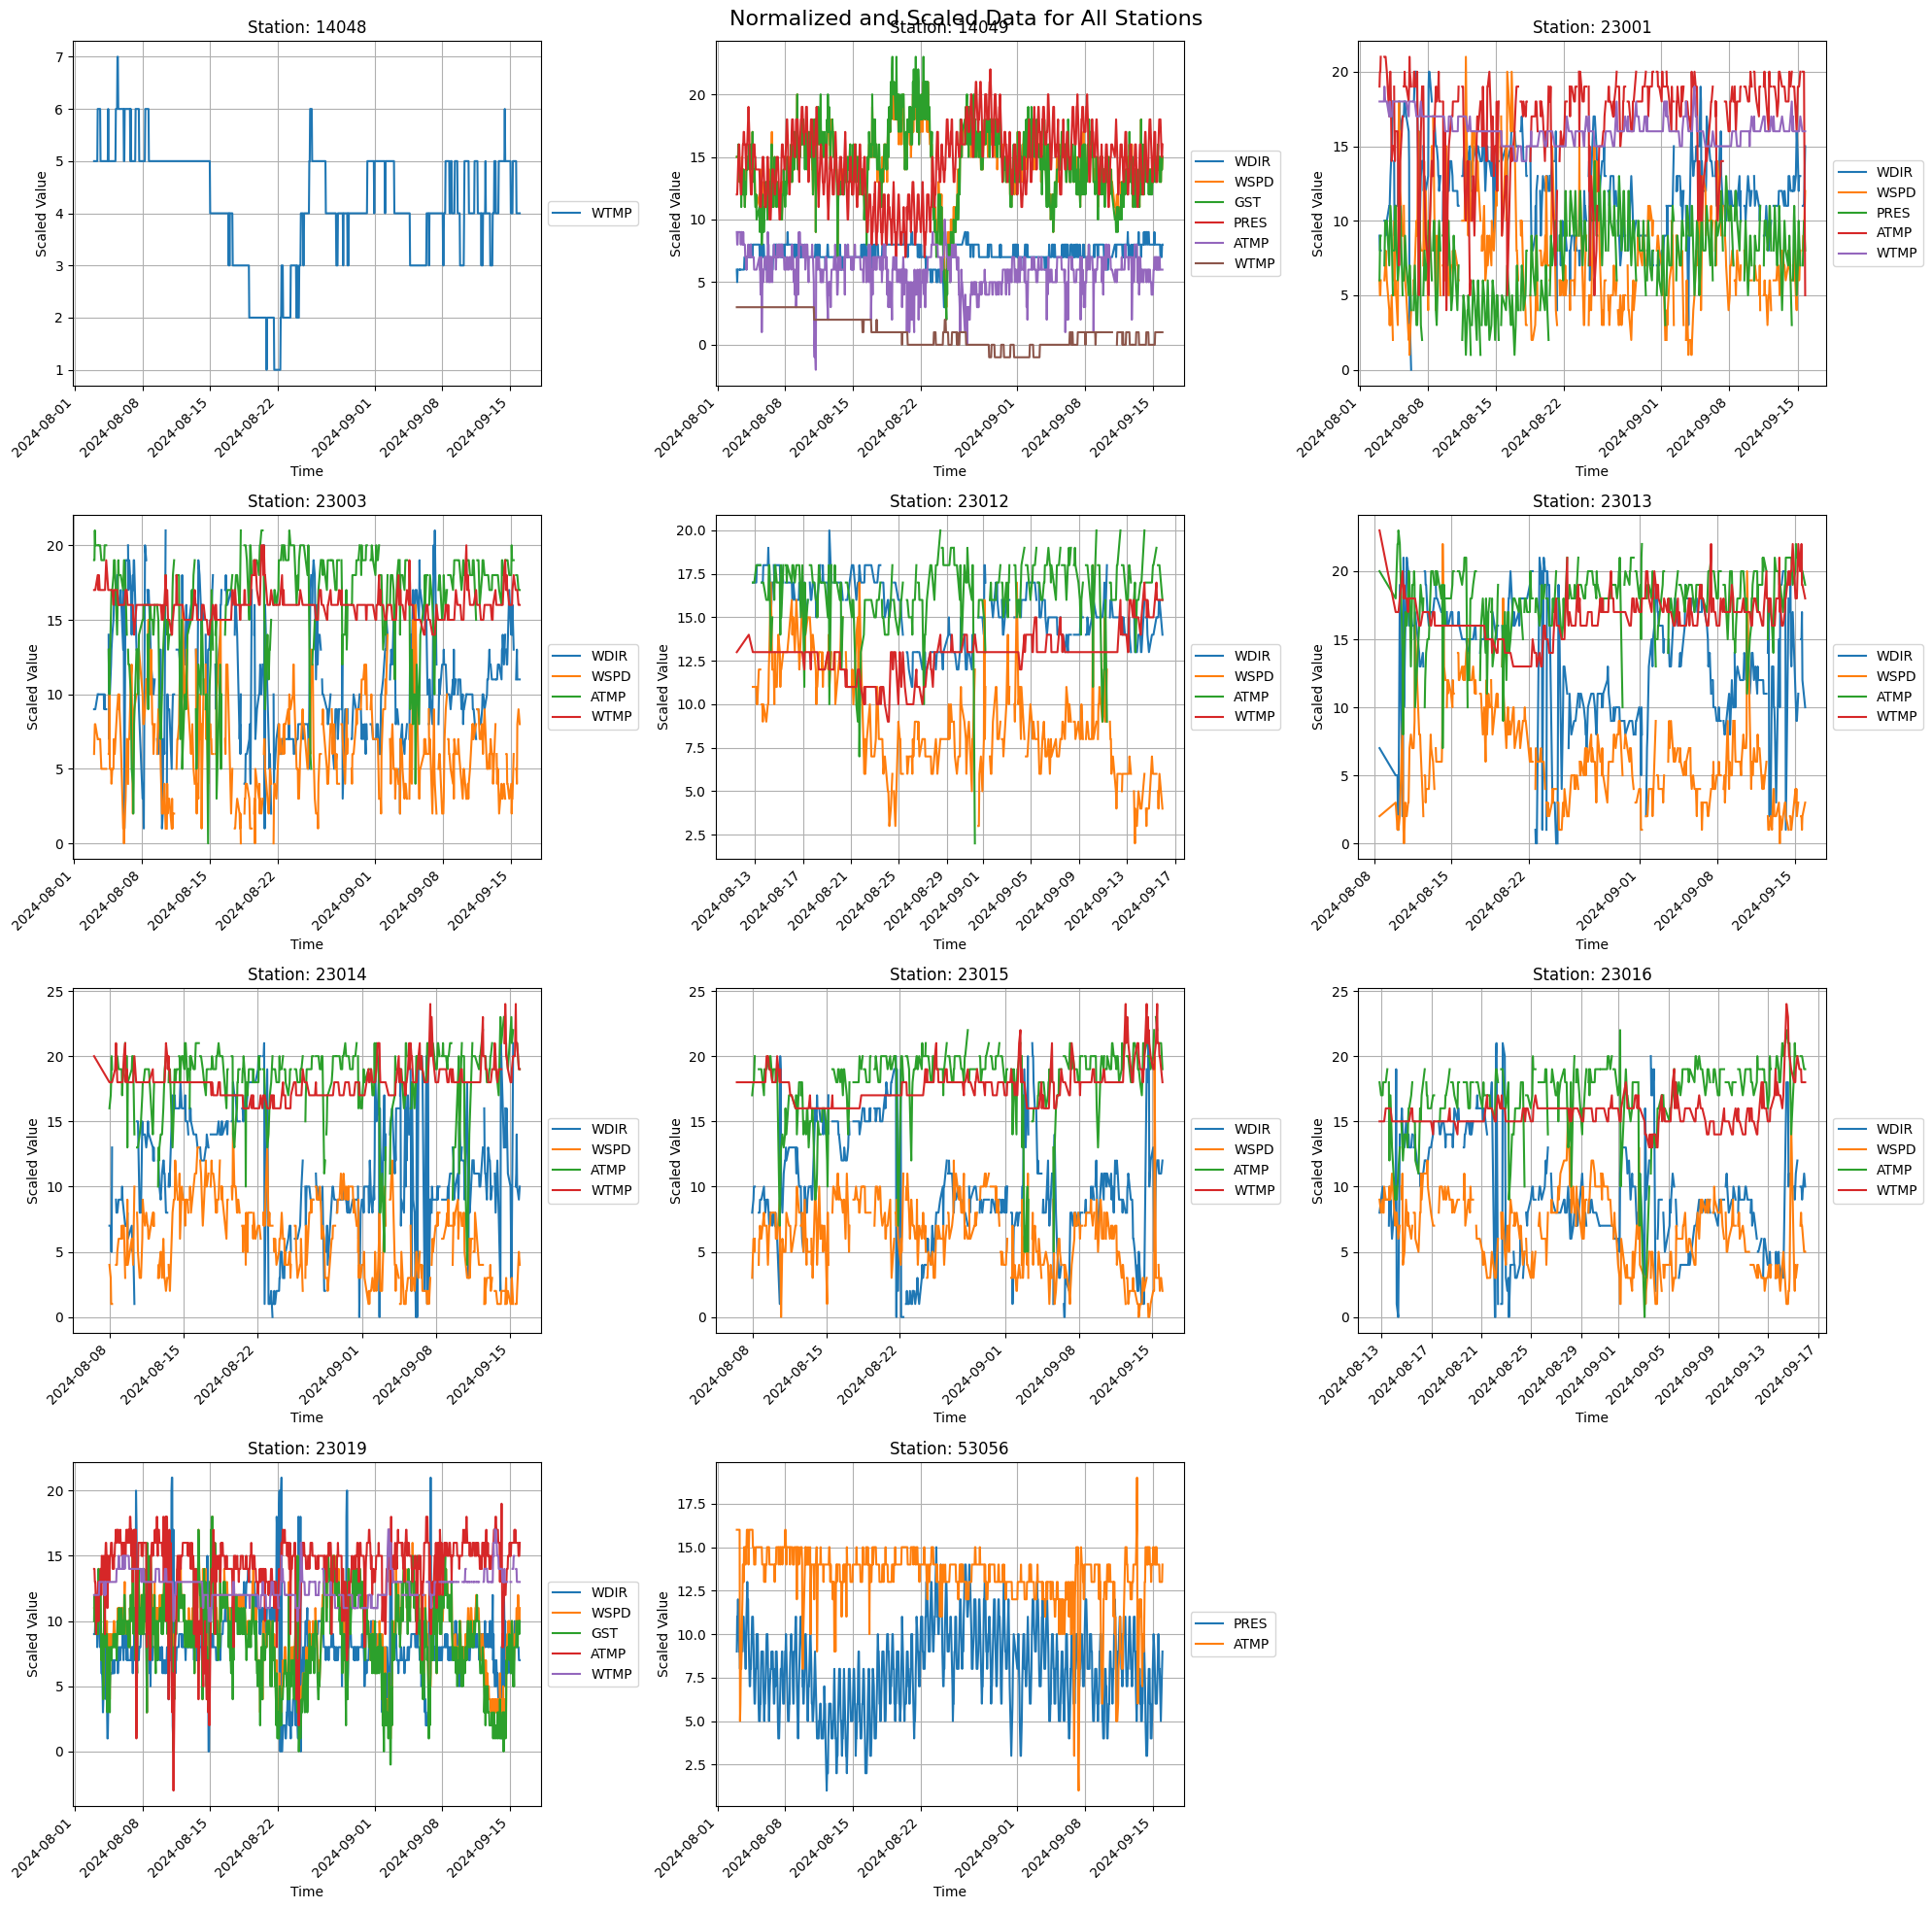

In [42]:
# Usage
plot_music_base_dict(indian_ocean_music_base_dict)

### Making it more musical

Ok, so to make it more musical we can use the modes, but it does not make sense to apply it to everything at once as each instrument has different ranges. So what makes sense is to assign the instruments first, and then to these instruments, make the music conversion. 

Definition of tempo must be made
Also, a way to assign music duration is to go through the music array and if the notes repeats, then just let it play. Something like max note duration variable can be assigned also, so if the note repeats 8 times, then the 9th time will play it again.

In [26]:
import json

# Load the JSON data from the file
with open('../MainAPI and assets/instrumentos_all.json', 'r', encoding='utf-8') as file:
    instrumentos = json.load(file)

**Channel 0**
- buoy 53056
- PRES
- Piano

**Channel 1**
- buoy 23014
- WTMP
- basses spiccato

**Channel 3**
- buoy 14049
- PRES
- Piccolo staccatissimo


In [27]:
tempo = 120
main_key = "C"
mode = "Ionian"

channel_data = [
    {
        "buoy": "53056",
        "variable": "PRES",
        "instrument": "Piano",
    },
    {
        "buoy": "23014",
        "variable": "WTMP",
        "instrument": "Contrabajo"
    },
    {
        "buoy": "14049",
        "variable": "PRES",
        "instrument": "Flautín"
    },
    {
        "buoy": "14049",
        "variable": "PRES",
        "instrument": "Flautín"
    }
]

In [28]:
# Define the intervals for each mode
modes = {
        'Ionian': [0, 2, 4, 5, 7, 9, 11],
        'Dorian': [0, 2, 3, 5, 7, 9, 10],
        'Phrygian': [0, 1, 3, 5, 7, 8, 10],
        'Lydian': [0, 2, 4, 6, 7, 9, 11],
        'Mixolydian': [0, 2, 4, 5, 7, 9, 10],
        'Aeolian': [0, 2, 3, 5, 7, 8, 10],
        'Locrian': [0, 1, 3, 5, 6, 8, 10]
    }

def get_midi_notes(mode='Ionian', midi_base=60, octaves=2):
    # Get the intervals for the specified mode
    intervals = modes.get(mode)
    
    if intervals is None:
        raise ValueError(f"Mode '{mode}' is not recognized.")
    # Create note mapping based on the input key and octave
    notes_midi = []
    for octave in range(octaves):
        notes_midi.extend([midi_base + interval + (octave * 12) for interval in intervals])

    return notes_midi

# Function to map a DataFrame column to MIDI notes
def map_to_midi(df_column, mode='Ionian', midi_base=0, octaves=2):
    midi_notes = get_midi_notes(mode, midi_base, octaves)
    # Map values from 0 to (7*octaves-1) to MIDI notes, casting to int
    midi_mapped = df_column.apply(lambda x: midi_notes[int(x)] if 0 <= x < 7*octaves and not pd.isna(x) else None)
    return midi_mapped

In [29]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'column': range(0, 21)})

print(map_to_midi(df["column"], mode='Ionian', midi_base=60, octaves=3))

0     60
1     62
2     64
3     65
4     67
5     69
6     71
7     72
8     74
9     76
10    77
11    79
12    81
13    83
14    84
15    86
16    88
17    89
18    91
19    93
20    95
Name: column, dtype: int64


In [ ]:
%pip install music21

In [30]:
import json
from music21 import pitch
import pandas as pd

def create_midi_progression(music_base_dict, channel_data, main_key, mode, octaves=5):
    # Load instrument data
    with open('../MainApi and assets/instrumentos_all.json', 'r', encoding='utf-8') as f:
        instruments = json.load(f)
    
    # Convert main_key to MIDI base note
    main_key_midi = pitch.Pitch(main_key).midi
    print(main_key_midi)
    
    # Initialize output list
    output_list = []
    
    # Process each channel
    for channel in channel_data:
        buoy = channel['buoy']
        print(buoy)
        variable = channel['variable']
        instrument_name = channel['instrument']
        
        # Get instrument data
        instrument = next((i for i in instruments if i['name'] == instrument_name), None)
        if not instrument:
            raise ValueError(f"Instrument {instrument_name} not found")
        
        # Find appropriate MIDI base
        low_midi = instrument['low_midi']
        high_midi = instrument['high_midi']
        
        # Calculate the first note in the instrument range that matches the main key
        midi_base = low_midi
        while midi_base % 12 != main_key_midi % 12:
            midi_base += 1
        
        # If the calculated midi_base is higher than the instrument's high_midi,
        # start from low_midi and go up by octaves until we're in range
        if midi_base > high_midi:
            midi_base = low_midi
            while midi_base % 12 != main_key_midi % 12:
                midi_base += 12
        
        # Ensure we have enough range for the specified number of octaves
        required_range = octaves * 12
        while midi_base + required_range > high_midi:
            midi_base -= 12
        
        # If we've gone below the low_midi, raise an error
        if midi_base < low_midi:
            print(f"Cannot fit {octaves} octaves within the instrument range")
        
        print(f"instrument:{instrument['name']}\nlow_midi:{low_midi}\nhigh_midi:{high_midi}\nmidi_base:{midi_base}\n")
        
        # Get data from the music_base_dict
        if buoy not in music_base_dict or variable not in music_base_dict[buoy].columns:
            raise ValueError(f"Data for buoy {buoy} and variable {variable} not found")
        
        data = music_base_dict[buoy][variable]
        
        print(data)
        
        # Map data to MIDI notes
        midi_mapped = map_to_midi(data, mode=mode, midi_base=midi_base, octaves=octaves)
         
        print(midi_mapped)
        
        # Create DataFrame for this channel
        df = pd.DataFrame({f"{instrument_name}_{variable}": midi_mapped})
    
        # Fill NaN values with None
        df = df.where(pd.notnull(df), None)
    
        # Add DataFrame to output list
        output_list.append(df)
    
    return output_list

# Example usage:
result = create_midi_progression(indian_ocean_music_base_dict, channel_data, "C", mode)

60
53056
instrument:Piano
low_midi:21
high_midi:108
midi_base:24

timestamp
2024-08-03 00:00:00     9
2024-08-03 01:00:00    11
2024-08-03 02:00:00    11
2024-08-03 03:00:00    12
2024-08-03 04:00:00    11
                       ..
2024-09-15 20:00:00     5
2024-09-15 21:00:00     6
2024-09-15 22:00:00     7
2024-09-15 23:00:00     8
2024-09-16 00:00:00     9
Name: PRES, Length: 1005, dtype: int64
timestamp
2024-08-03 00:00:00    40
2024-08-03 01:00:00    43
2024-08-03 02:00:00    43
2024-08-03 03:00:00    45
2024-08-03 04:00:00    43
                       ..
2024-09-15 20:00:00    33
2024-09-15 21:00:00    35
2024-09-15 22:00:00    36
2024-09-15 23:00:00    38
2024-09-16 00:00:00    40
Name: PRES, Length: 1005, dtype: int64
23014
Cannot fit 5 octaves within the instrument range
instrument:Contrabajo
low_midi:28
high_midi:72
midi_base:12

timestamp
2024-08-06 12:00:00    20.0
2024-08-07 23:00:00    18.0
2024-08-08 02:00:00    18.0
2024-08-08 03:00:00    18.0
2024-08-08 04:00:00    18.

In [31]:
import mido
import time

print("Output ports:", mido.get_output_names())
print("Input ports:", mido.get_input_names())

Output ports: ['Microsoft GS Wavetable Synth 0', 'MPKmini2 1', 'Python2Reaper 2', 'IAC Driver Bus 1 3']
Input ports: ['MPKmini2 0', 'Python2Reaper 1', 'IAC Driver Bus 1 2']


In [32]:
# Define the MIDI port (you may need to adjust this)
port_name = 'IAC Driver Bus 1 3'

# Create a MIDI output
#outport = mido.open_output(port_name)

In [33]:
import mido
import time

import pandas as pd
import numpy as np

def play_midi_progression(progression, tempo, outport):
    # Calculate delay based on tempo (beats per minute)
    delay = 60 / tempo  # seconds per beat

    # Initialize dictionaries to keep track of currently playing notes for each channel
    current_notes = {}

    # Determine the length of the progression
    max_length = max(len(df) for df in progression)

    for i in range(max_length):
        for channel, df in enumerate(progression):
            if i < len(df):
                column_name = df.columns[0]  # Get the name of the only column
                note = df.iloc[i][column_name]
                
                if pd.notna(note) and not np.isnan(note):
                    try:
                        note = int(note)
                    
                        # If there's a currently playing note for this channel and it's different
                        if channel in current_notes and current_notes[channel] != note:
                            # Send note off for the previous note
                            msg_off = mido.Message('note_off', note=current_notes[channel], velocity=64, channel=channel)
                            outport.send(msg_off)
                        
                        # If it's a new note or a different note from the previous one
                        if channel not in current_notes or current_notes[channel] != note:
                            # Send note on for the new note
                            msg_on = mido.Message('note_on', note=note, velocity=64, channel=channel)
                            outport.send(msg_on)
                            current_notes[channel] = note
                    except ValueError:
                        # If the note can't be converted to an integer, ignore it
                        pass
                
                elif channel in current_notes:
                    # If there's no valid note and there was a note playing, stop it
                    msg_off = mido.Message('note_off', note=current_notes[channel], velocity=64, channel=channel)
                    outport.send(msg_off)
                    del current_notes[channel]

        # Wait for the duration of one beat
        time.sleep(delay)

    # After the progression ends, turn off any remaining notes
    for channel, note in current_notes.items():
        msg_off = mido.Message('note_off', note=note, velocity=64, channel=channel)
        outport.send(msg_off)




In [1]:
tempo = 240

# Example usage:
outport = mido.open_output(port_name)  # Replace with your MIDI output port name

try:
    play_midi_progression(result, tempo, outport)
finally:
    outport.close()

NameError: name 'mido' is not defined

In [35]:
tempo = 180
main_key = "C"
mode = "Mixolydian"

channel_data = [
    {
        "buoy": "53056",
        "variable": "PRES",
        "instrument": "Piano",
    },
    {
        "buoy": "23014",
        "variable": "WTMP",
        "instrument": "Contrabajo"
    },
    {
        "buoy": "14049",
        "variable": "PRES",
        "instrument": "Flautín"
    },
    {
        "buoy": "23016",
        "variable": "WDIR",
        "instrument": "Arpa"
    }
]

In [36]:
result = create_midi_progression(indian_ocean_music_base_dict, channel_data, main_key, mode)
play_midi_progression(result,tempo,outport)


: 